DiffDIS
====

**High-Precision Dichotomous Image Segmentation via Probing Diffusion Capacity**

 * Paper: https://arxiv.org/abs/2410.10105

![DiffDIS Overview](../assets/diffdis_overview.png)



! Installation

```bash
git clone https://github.com/qianyu-dlut/DiffDIS.git
cd DiffDIS

pip install torch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 --index-url https://download.pytorch.org/whl/cu118
pip install -r requirements.txt
pip install -e diffusers-0.30.2/
```



 * Download pre-trained model (sd-ultra)
```python
...: from huggingface_hub import snapshot_download
...: 
...: # Replace this with your target directory
...: local_dir = "./models/sd-turbo"
...: 
...: # Download entire repository snapshot
...: snapshot_download(
...:     repo_id="stabilityai/sd-turbo",
...:     local_dir=local_dir,
...:     local_dir_use_symlinks=False  # Set to False to copy files instead of symlinks
...: )
```

 * Download the checkpoint from [Google Drive](https://drive.google.com/drive/folders/1NKmUbn9BiV7xYy_1c2khIBAuOQNuYAdR)

```bash
pip install gdown

# Right click on the file and get the link

gdown https://drive.google.com/uc?id=FILE_ID
```

In [1]:
import os
import sys

import numpy as np
import torch
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from torchvision import transforms
from transformers import CLIPTextModel, CLIPTokenizer

sys.path.append("DiffDIS-repo")
from core.diffdis_pipeline import DiffDISPipeline
from diffusers import (
    DDPMScheduler,
    UNet2DConditionModel_diffdis,
    AutoencoderKL,
)

from utils.seed_all import seed_all 
from utils.utils import check_mkdir
from utils.config import diste1,diste2,diste3,diste4,disvd
from utils.image_util import resize_res

to_pil = transforms.ToPILImage()


/home/pyml/anaconda3/envs/diffdis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
use_seperate = False
    
checkpoint_path = "DiffDIS-repo/checkpoints/"
pretrained_model_path = "DiffDIS-repo/models/sd-turbo"
      
# Diffusion denoising steps, more steps results in higher accuracy but slower inference speed
denoise_steps = 1
# Number of predictions to be ensembled, more inference gives better results but runs slower.
ensemble_size = 1
# Run with half-precision (16-bit float), might lead to suboptimal result.
half_precision = False
# Maximum resolution of processing. 0 for using input image resolution. Default: 1024.
processing_res = 1024
# Match input resolution for output depth. Default: False.
match_input_res = True
# Random seed for reproducibility
seed = None
# Inference batch size. Default: 0 (will be set automatically).
batch_size = 1

match_output_input_res = False

    
# -------------------- Preparation --------------------
# Random seed
if seed is None:
    import time
    seed = int(time.time())
seed_all(seed)

# -------------------- Device --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import ttach as tta
transforms = tta.Compose(
[
    tta.HorizontalFlip(),
    tta.Scale(scales=[0.75, 1, 1.25], interpolation='bilinear', align_corners=False),
])
    
dtype = torch.float16 if half_precision else torch.float32

In [3]:
# -------------------- Model --------------------
    
vae = AutoencoderKL.from_pretrained(
    pretrained_model_path, subfolder='vae'
)
scheduler = DDPMScheduler.from_pretrained(
    pretrained_model_path, subfolder='scheduler'
)
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_path, subfolder='text_encoder'
)
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_path, subfolder='tokenizer'
)
unet = UNet2DConditionModel_diffdis.from_pretrained(
    checkpoint_path, subfolder="unet",
    in_channels=8, sample_size=96,
    low_cpu_mem_usage=False,
    ignore_mismatched_sizes=False,
    class_embed_type='projection',
    projection_class_embeddings_input_dim=4,
    mid_extra_cross=True,
    mode = 'DBIA', use_swci = True
)

pipe = DiffDISPipeline(
    unet=unet,
    vae=vae,
    scheduler=scheduler,
    text_encoder=text_encoder,
    tokenizer=tokenizer
)
print("Using Seperated Modules")
    

pipe = pipe.to(device);

Using Seperated Modules


In [4]:
# -------------------- Inference --------------------
def run_inference(input_image_pil):
    w_,h_ = input_image_pil.size
    img_resize = resize_res(input_image_pil, resolution=processing_res)

    input_image = img_resize.convert("RGB")
    image = np.array(input_image)
    rgb = np.transpose(image,(2,0,1))
    rgb_norm = rgb / 255.0 * 2.0 - 1.0
    rgb_norm = torch.from_numpy(rgb_norm).to(device)
    rgb_norm = rgb_norm.to(device).float().unsqueeze(0)
    mask_m = []
    mask_e = []
    for transformer in transforms:
        img_resize = transformer.augment_image(rgb_norm)
        with torch.no_grad():
            pipe_out_m, pipe_out_e = pipe(
                img_resize,
                denosing_steps=denoise_steps,
                ensemble_size=ensemble_size,
                processing_res=processing_res,
                match_input_res=match_input_res,
                batch_size=batch_size,
                show_progress_bar=True
            )
        deaug_mask_m = transformer.deaugment_mask(pipe_out_m.unsqueeze(0).unsqueeze(0))
        mask_m.append(deaug_mask_m)
        deaug_mask_e = transformer.deaugment_mask(pipe_out_e.unsqueeze(0).unsqueeze(0))
        mask_e.append(deaug_mask_e)


    prediction_m = torch.mean(torch.stack(mask_m, dim=0), dim=0)
    prediction_e = torch.mean(torch.stack(mask_e, dim=0), dim=0)

    prediction_m = to_pil(prediction_m.data.squeeze(0).cpu())
    prediction_m = prediction_m.resize((w_, h_), Image.BILINEAR)
    
    prediction_e = to_pil(prediction_e.data.squeeze(0).cpu())
    prediction_e = prediction_e.resize((w_, h_), Image.BILINEAR)

    return prediction_m, prediction_e


In [5]:
image_path = "../samples/plants.jpg"
input_image_pil = Image.open(image_path)
print(input_image_pil.size)

pred_m, pred_e = run_inference(input_image_pil)

pred_m.size, pred_e.size

(1068, 1137)


((1068, 1137), (1068, 1137))

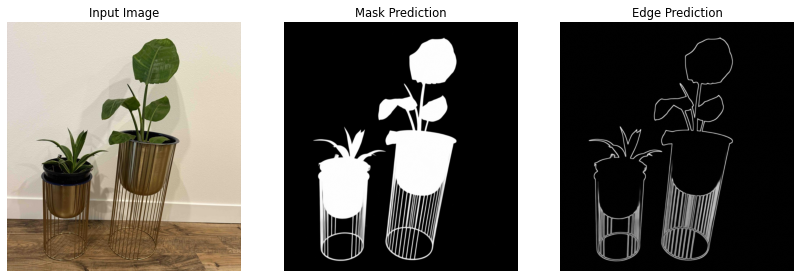

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=70)
axes[0].imshow(input_image_pil)
axes[0].set_title("Input Image")
axes[1].imshow(pred_m, cmap='gray')
axes[1].set_title("Mask Prediction")
axes[2].imshow(pred_e, cmap='gray')
axes[2].set_title("Edge Prediction")
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()